## Loading of Miller ECoG data of the memory nback task

includes some visualizations

In [ ]:
#@title Setup
!apt-get install r-base
!pip install nimare nilearn duecredit rpy2 yasa --quiet

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages('devtools')
library('devtools')
install_github('yunshiuan/label4MRI')

In [4]:
#@title Data retrieval
import os, requests

FILE = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

if not os.path.isfile(FILE):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(FILE, "wb") as fid:
        fid.write(r.content)

In [5]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import yasa

from nilearn import plotting  
from nimare import utils
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import periodogram, welch
from scipy.integrate import simps
from sklearn import preprocessing
from rpy2.robjects.packages import importr

l4m = importr('label4MRI')


CH_TYPE = 'ecog'
SAMP_RATE = 1_000   # Hz
TASKS = ['0-back', '1-back', '2-back']
SUBJECT = 1
TASK = TASKS[0]

def load_data(file, subject, task='0-back'):
  all_data = np.load(file, allow_pickle=True)['dat']
  for idx, person in enumerate(all_data):
    if idx == subject:
      for data in person:
        if data['expinfo'] == task:
          data['V'] = data['V'].astype(np.float32)  # most important
          print(f'Subject: {idx}, doing {task}')
          return (data['V'], data['stim_id'], data['t_on'], data['t_off'],
                  data['target'], data['response'], data['rt'], data['locs'])

V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, SUBJECT, TASK)

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Subject: 1, doing 0-back


# Dataset info #

- 3 sessions from 3 subjects
- references using other datasets may be useful for the memory n-back task: 

    *Brouwer, Anne-Marie, et al. "Estimating workload using EEG spectral power and ERPs in the n-back task." Journal of neural engineering 9.4 (2012): 045008.*

    *Grissmann, Sebastian, et al. "Electroencephalography based analysis of working memory load and affective valence in an n-back task with emotional stimuli." Frontiers in human neuroscience 11 (2017): 616.*

Each subject's data is divided into 5 sessions: fixation, exp1, exp2, exp3, fixation.

- Exp1 is a "0-back" memory experiment, where the subjects have to identify the picture of one of the houses (stimid = 10), which they have memorized at the beginning of the stimulus block.
- Exp2 is a 1-back memory experiment, where the participants have to respond to images of repeated houses.
- exp3 is 2-back where participants respond to pictures of houses that are repeated after another intervening random picture.

This task was hard for these participants and most of them did not really respond at all, but the data can still be used to ask questions:

- about overall shifts of neural activity in a hard task when the subjects feel overwhelmed by the memory requirements.

Note that for the third/last subject, no response data was collected, so only the first two subjects can be analyzed for their correct / incorrect trials.

ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size.

Variables for each block within each subject:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['expinfo']`: experiment type for this block
* `dat['srate']`: sampling rate for voltage data, always 1000Hz
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, usually 600 samples after `t_on`
* `dat['stim_id`]: identity of house stimulus from 1 to 40. Stimulus 10 was the target in the 0-back task.  
* `dat['target']`: 0 or 1, indicates if this stimulus requires a response
* `dat['response']`: 0 or 1, indicates if the subject actually made a response
* `dat['rt']`: reaction time for trials with a response in voltage data samples (1000Hz). 
* `dat['locs']`: 3D locations of the electrodes on the cortical surface

In [6]:
def bandpass(sig, mn, mx):
  res = copy.deepcopy(sig).astype('float32') # always convert the voltage data to float32!

  b, a = signal.butter(3, [mx], btype = 'low', fs=SAMP_RATE)
  res = signal.filtfilt(b, a, res, 0)

  b, a = signal.butter(6, [mn], btype = 'high', fs=SAMP_RATE)
  res = signal.filtfilt(b, a, res, 0)
  return res

# compute spectral power above 50Hz and low-pass below 10Hz
# power is always positive, so we normalize it by its average
def get_power(V, mn=50, mx=125):
    pwr = bandpass(V, mn, mx)

    # compute smooth envelope of this signal = approx power
    pwr = np.abs(pwr)**2
    b, a = signal.butter(3, [10], btype = 'low', fs=SAMP_RATE)
    pwr = signal.filtfilt(b, a, pwr, 0)

    # normalize each channel so its mean power is 1
    pwr = pwr/pwr.mean(0)
    return pwr

In [7]:
# for subject in range(3):
#   for task in TASKS:
#     V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, subject, task)
#     ba_names = []
#     for loc in locs:
#       x, y, z = map(int, loc)
#       nm = l4m.mni_to_region_name(x=x, y=y, z=z)
#       ba_names.append(list(nm)[3].__str__().split('"')[1])

#     names = [f'{ba_names[elec]} {elec}' for elec in range(len(locs))]

#     nt, nchan = V.shape
#     nstim = len(t_on)

#     # use a timerange from 400ms before to 1600ms after the stimulus onset
#     trange = np.arange(-400, 1600)
#     ts = t_on[:,np.newaxis] + trange
#     V_epochs = np.reshape(get_power(V)[ts, :], (nstim, 2000, nchan))
#     # plt.figure(figsize=(18, 18))
#     # for i in range(V_epochs.shape[2]):
#     #   im = V_epochs[:, :, i]
#     #   plt.subplot(V_epochs.shape[2], 1, i+1)
#     #   plt.imshow((im - im.min()) / (im.max() - im.min()), cmap='gray')
#     # plt.show()


In [8]:
ba_names = []
for loc in locs:
  x, y, z = map(int, loc)
  nm = l4m.mni_to_region_name(x=x, y=y, z=z)
  ba_names.append(list(nm)[3].__str__().split('"')[1])


names = [(f'{ba_names[elec]} {elec}' if '25' in ba_names[elec] else f'{elec}') for elec in range(len(locs))]

def plt_3D_electrodes(locs):
  plt.figure(figsize=(8,8))
  view = plotting.view_markers(utils.tal2mni(locs), marker_labels  = [names[k] for k in np.arange(locs.shape[0])], marker_color = 'purple', marker_size=5)
  return view

view = plt_3D_electrodes(locs)
view

<Figure size 576x576 with 0 Axes>

In [9]:
del view

In [10]:
V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, SUBJECT, TASK)

# divide into trials and average
nt, nchan = V.shape
nstim = len(t_on)

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-400, 1600)
ts = t_on[:,np.newaxis] + trange
V_epochs = np.reshape(get_power(V, 50, 125)[ts, :], (nstim, 2000, nchan))

V_resp = (V_epochs[target==1]).mean(0)
V_base  = (V_epochs[target==0]).mean(0)

Subject: 1, doing 0-back


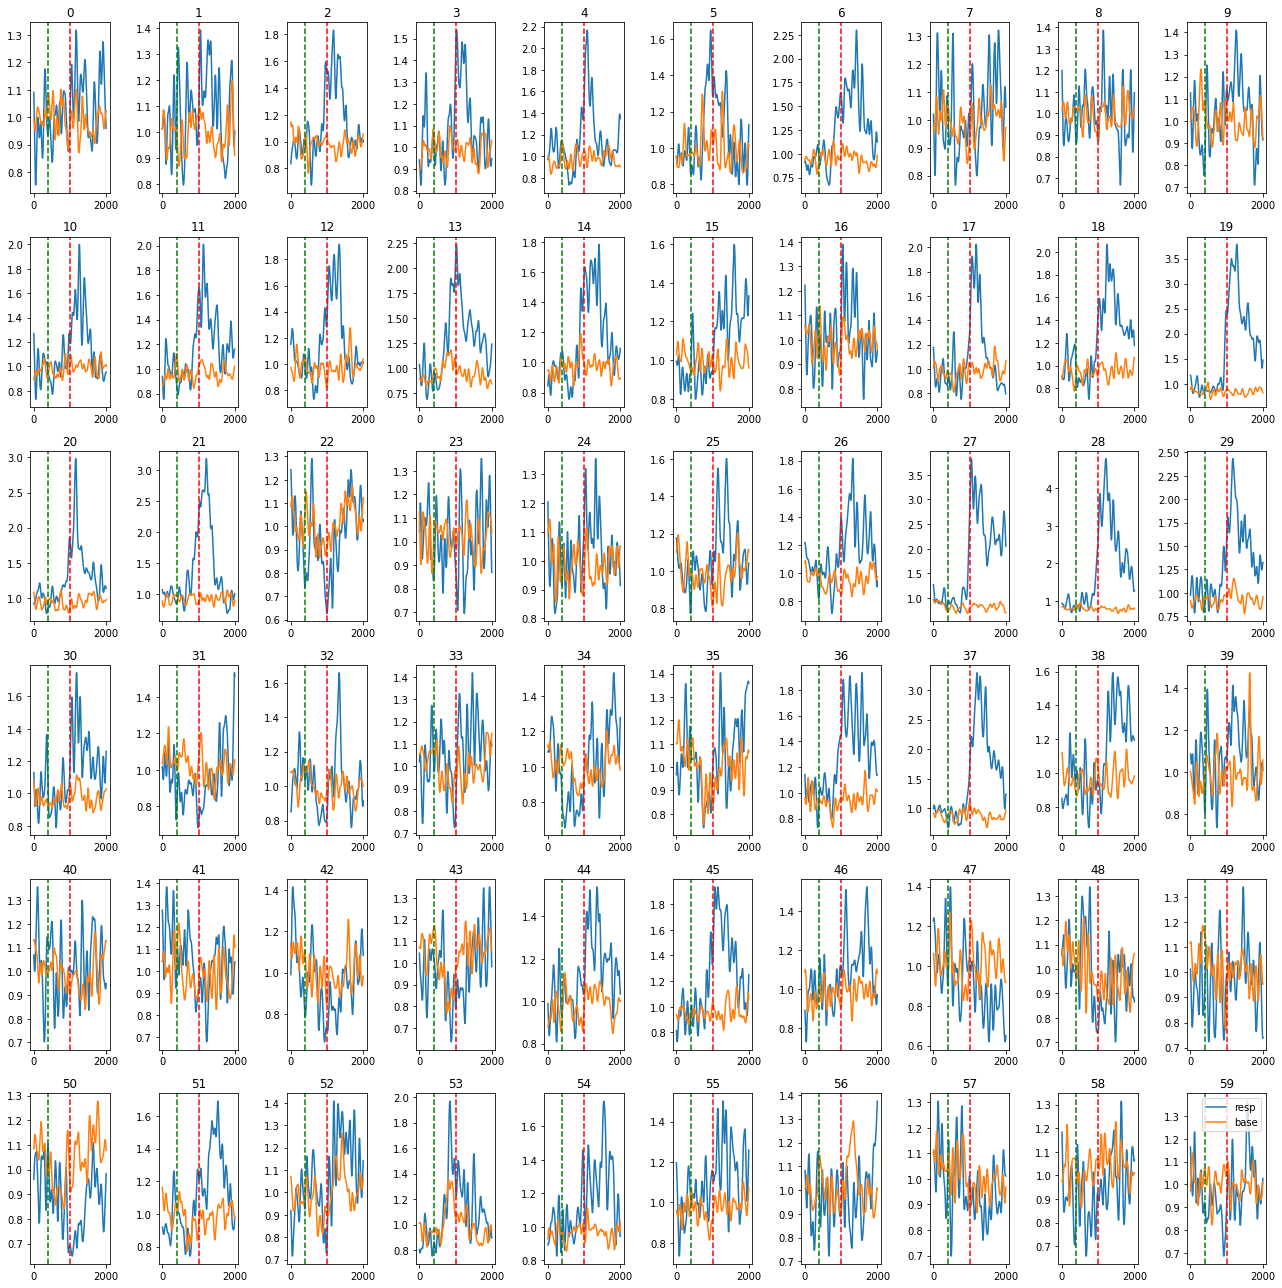

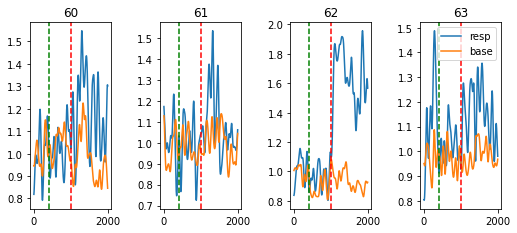

In [11]:
# let's find the electrodes that distinguish responses from non-responses
# note these are event-related potentials

def plt_stats_all_electrodes(stats, labels):
  '''
    stats: list of (n_electrodes, n_samples)
  '''
  N_ELECTRODES = stats[0].shape[0]
  for left_elecs in range(0, N_ELECTRODES, 60):
    plt.figure(figsize=(18, 18))
    for n_elec in range(left_elecs, min(left_elecs + 60, N_ELECTRODES)):
      ax = plt.subplot(6,10,n_elec - left_elecs +1)
      for i, stat in enumerate(stats):
        plt.plot(stat[n_elec], label=labels[i])
      plt.title(f'{n_elec}')
      plt.axvline(x=400, color='g', linestyle='dashed')
      plt.axvline(x=1000, color='r', linestyle='dashed')
    plt.legend(); plt.tight_layout(); plt.show()

plt_stats_all_electrodes([V_resp.T, V_base.T], ['resp', 'base'])

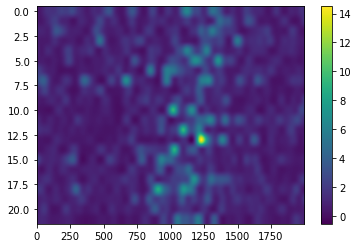

In [12]:
# let's look at all the response trials for the electrode that has a significant response
plt.imshow(V_epochs[response==1,:,21].astype('float32'), aspect='auto')
plt.colorbar()

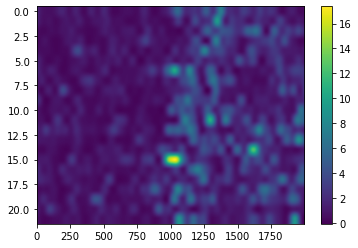

In [13]:
# this electrode has a more transient response
plt.imshow(V_epochs[response==1,:,27].astype('float32'), aspect='auto')
plt.colorbar()

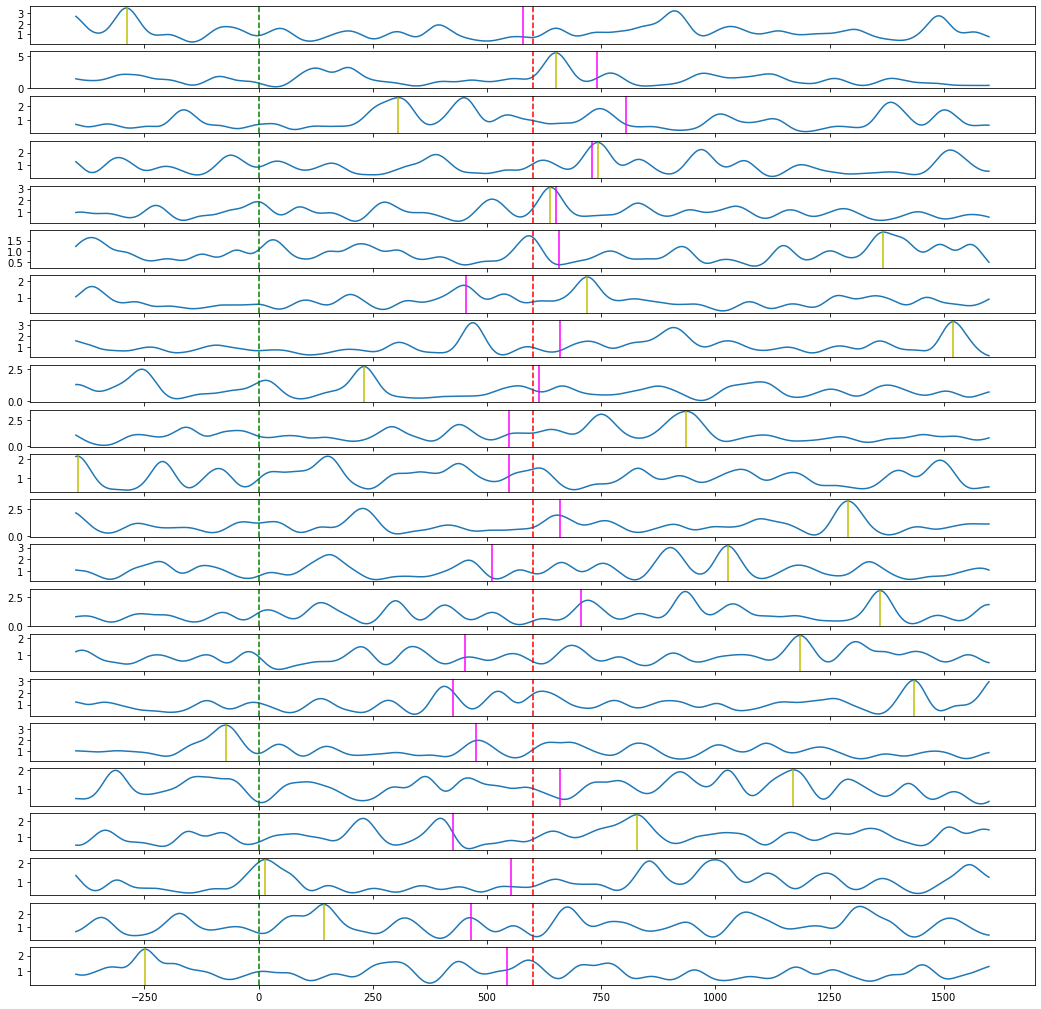

In [14]:
# to do: do these responses covary with the reaction times? are they present on trials where there is no motor response?
N_ELEC = 16
START_BEFORE = 400
N_TARGETS = 22
V_epochs[response==1, :, N_ELEC].shape  # (ntrials, nsamples)
plt.figure(figsize=(18, 18))
for i in range(N_TARGETS):
  ax = plt.subplot(N_TARGETS, 1, i+1)
  plt.plot(np.arange(-400, 1600), V_epochs[response==1, :, N_ELEC][i])
  plt.axvline(x=0, color='g', linestyle='dashed')
  plt.axvline(x=600, color='r', linestyle='dashed')
  plt.axvline(x=rt[response==1][i], color='magenta')
  plt.axvline(x=V_epochs[response==1, :, N_ELEC][i].argmax() - START_BEFORE, color='y')

# Analysis 1: Distractor vs Target in 0-back - Compute mean band amplitude

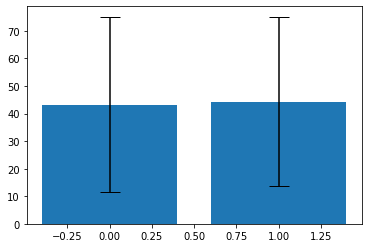

In [15]:
def get_epochs(V, start_pts, end_pts):
  epochs = []
  for i in range(len(start_pts)):
    epochs.append(V[start_pts[i]:end_pts[i]].T)
  epochs = np.array(epochs)
  return epochs

def get_mean_band_amp(epochs, mn=50, mx=125):
  mean_band_amp = []
  fourier = []

  for i, ecog in enumerate(epochs):
    mean_band_amp.append([])
    fourier.append([])
    for electrode in ecog:
      fft_freq = np.fft.rfftfreq(electrode.shape[0], 1.0/SAMP_RATE)
      fft_vals = np.abs(np.fft.rfft(electrode)) ** 2

      bands = {'Delta': (0, 3.5), 'Theta': (3.5, 8), 'Alpha': (8, 14),
              'Beta': (14, 30), 'Gamma': (30, 50), 'Hi-gamma': (50, 125),
              'Ripple': (125, 250)}

      band_fft = []
      for band in bands:
        f_min, f_max = bands[band]
        freq_ix = np.where((fft_freq >= f_min) & 
                           (fft_freq <= f_max))[0]
        band_fft.append(fft_vals[freq_ix].mean())
      mean_band_amp[i].append(band_fft)
      fourier[i].append(fft_vals[np.where((fft_freq >= mn) &
                                          (fft_freq <= mx))])

  return np.array(fourier), np.array(mean_band_amp)

def split_labeled_groups(band_stats, labels):
  mat1, mat2 = [], []
  for i, epoch in enumerate(band_stats):
    if labels[i] == 0:
      mat1.append(epoch)
    else:
      mat2.append(epoch)
  mat1, mat2 = np.array(mat1), np.array(mat2)
  return mat1, mat2

def compare_band_stats(group1, group2, band):
  plt.bar(range(2), [group1[:, :, band].mean(), group2[:, :, band].mean()],
          yerr=[group1[:, :, band].std(), group2[:, :, band].std()],
          capsize=10)
  plt.show()

epochs = get_epochs(V, t_on, t_off)
all_fft, mean_band_amp = get_mean_band_amp(epochs)
distractor_ecog, target_ecog = split_labeled_groups(mean_band_amp, target)
compare_band_stats(distractor_ecog, target_ecog, 5)

# Analysis 2: Distractor vs Target - Fourier transforms

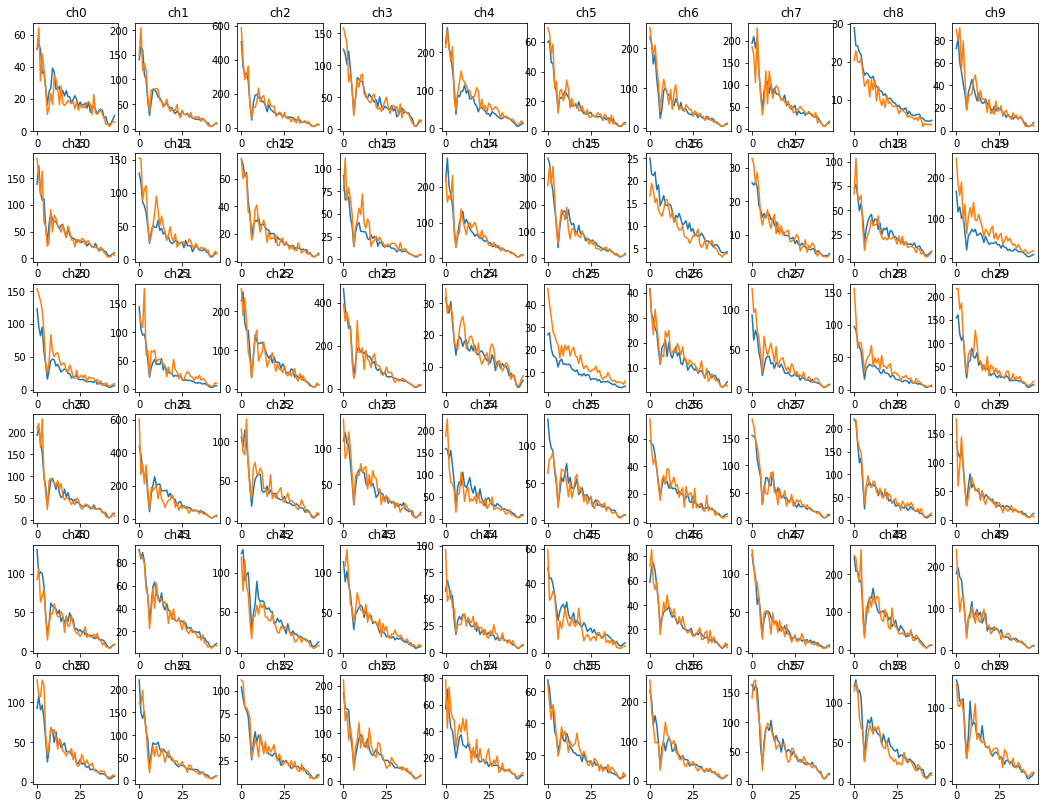

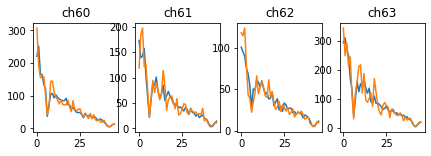

In [16]:
distractor_ecog_fft, target_ecog_fft = split_labeled_groups(all_fft, target)
plt.figure(figsize=(18,14))
for j in range(60):
  ax = plt.subplot(6,10,j+1)
  plt.plot(distractor_ecog_fft.mean(0)[j])
  plt.plot(target_ecog_fft.mean(0)[j])
  plt.title('ch%d'%j)
plt.show()
plt.figure(figsize=(18,14))
for j in range(60, 64):
  ax = plt.subplot(6,10,j-59)
  plt.plot(distractor_ecog_fft.mean(0)[j])
  plt.plot(target_ecog_fft.mean(0)[j])
  plt.title('ch%d'%j)

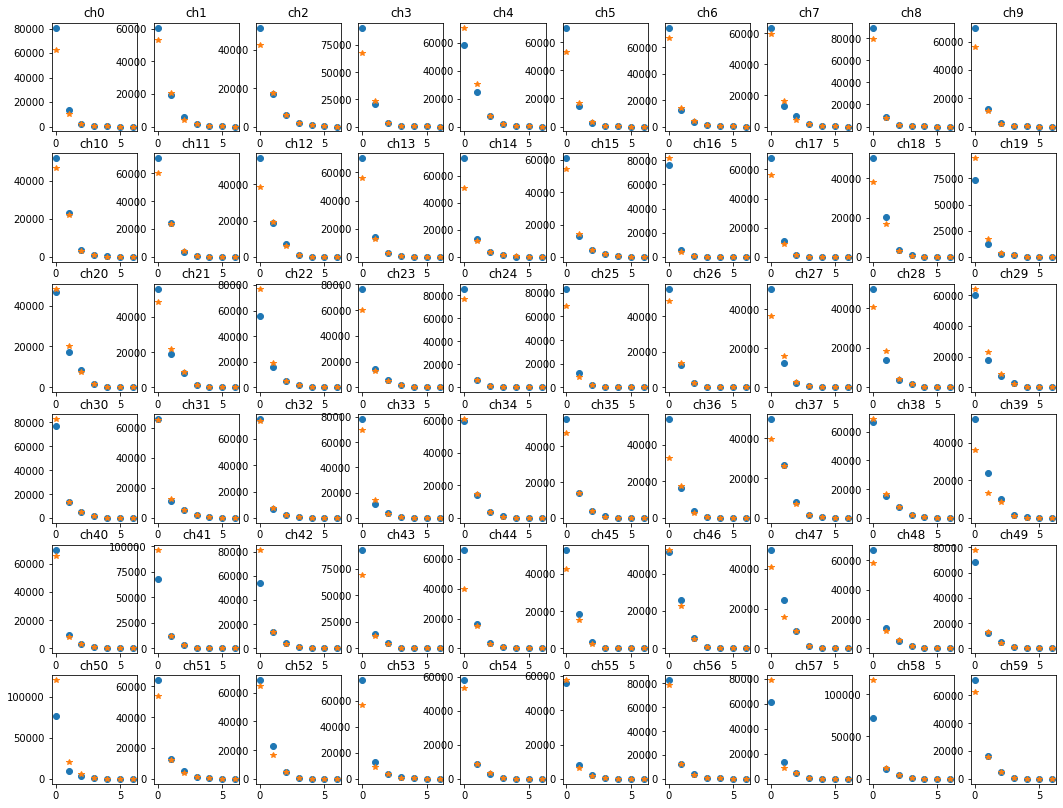

In [17]:
plt.figure(figsize=(18,14))
for j in range(60):
  ax = plt.subplot(6,10,j+1)
  plt.plot(distractor_ecog.mean(0)[j], 'o')
  plt.plot(target_ecog.mean(0)[j], '*')
  plt.title('ch%d'%j)

# Analysis 3: Workload across tasks

In [18]:
"""
'Right-PrimAuditory (41)',
'Right-BA9': PFC,
'Right-BA6': premotor,
'Right-PrimMotor (4)': motor,
'Right-BA45': broca/pfc,
'Right-BA44': broca/pfc,
'Right-BA22': auditory association,
'Right-BA47': ventrolateral pfc,
'Right-BA38': anterior end of temporal lobe (),
'Right-BA40': parietal (supramarginal),
'Right-BA10': lateral frontopolar cortex,
'Right-BA46': dorsolateral pfc (imitation),
'Right-PrimSensory (1)',
'Right-BA21': mid temporal area (higher order visual association),
'Right-BA8': premotor/pfc?
"""

"\n'Right-PrimAuditory (41)',\n'Right-BA9': PFC,\n'Right-BA6': premotor,\n'Right-PrimMotor (4)': motor,\n'Right-BA45': broca/pfc,\n'Right-BA44': broca/pfc,\n'Right-BA22': auditory association,\n'Right-BA47': ventrolateral pfc,\n'Right-BA38': anterior end of temporal lobe (),\n'Right-BA40': parietal (supramarginal),\n'Right-BA10': lateral frontopolar cortex,\n'Right-BA46': dorsolateral pfc (imitation),\n'Right-PrimSensory (1)',\n'Right-BA21': mid temporal area (higher order visual association),\n'Right-BA8': premotor/pfc?\n"

Subject: 0, doing 0-back
Subject: 0, doing 2-back
(200, 31) (200,)
0.8166666666666667
[-0.11637688 -0.02467358 -1.42842296  0.16673646  0.57885669  0.45242759
  0.25573867  0.00723053 -0.5354992  -0.55552696 -0.58690419  0.9558768
 -0.15087699  0.27490499  0.46697334  0.26633641 -0.04873915  0.46370245
 -0.01734004 -0.18407764 -0.08140759 -0.26185974 -0.3405779   0.25966375
 -0.17878416  0.46739327  0.42934553 -0.96495532  0.23484803  0.64046905
 -0.5272283 ]


<Figure size 1296x1008 with 0 Axes>

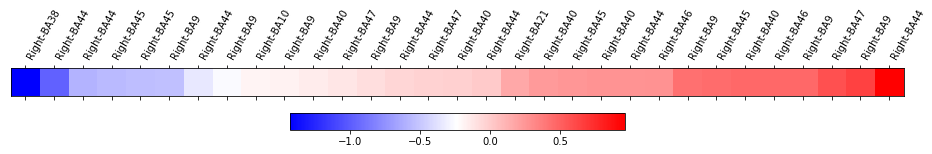

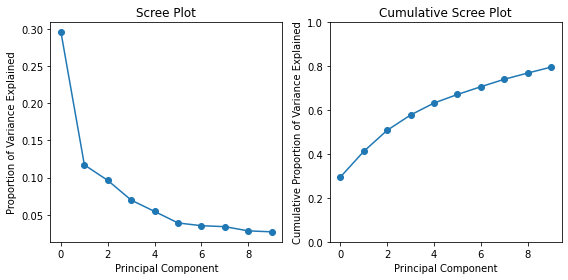

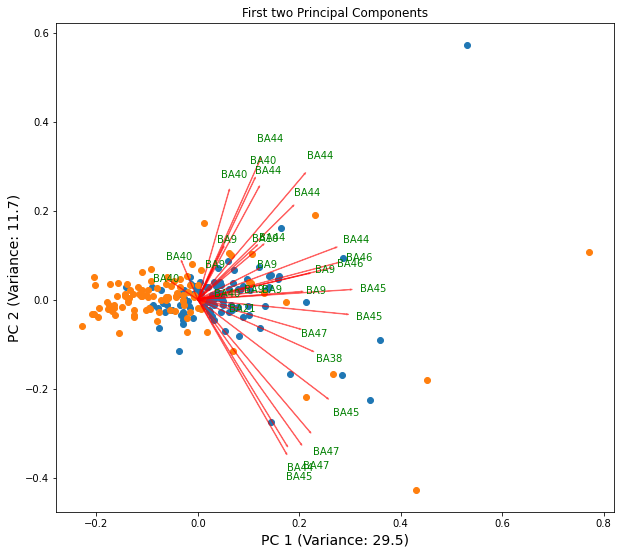

Subject: 1, doing 0-back
Subject: 1, doing 2-back
(200, 29) (200,)
0.95
[ 1.31233589  0.69685572  1.2574721   0.539161    1.51395743 -0.18626234
 -0.19061409 -0.67489525  0.06035401  0.37524023  0.53825986 -0.84403513
 -0.3335229   0.41670564  0.34518505  0.08462324 -0.65597479  0.33443838
 -0.88793432  0.490297    0.48178264  0.01977935 -0.38921889 -0.39605059
  0.77997451 -0.21779323  0.59010363  0.42186377  0.05043925]


<Figure size 1296x1008 with 0 Axes>

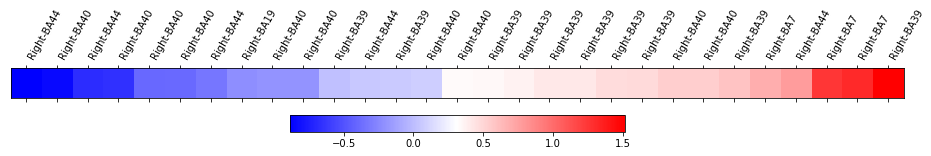

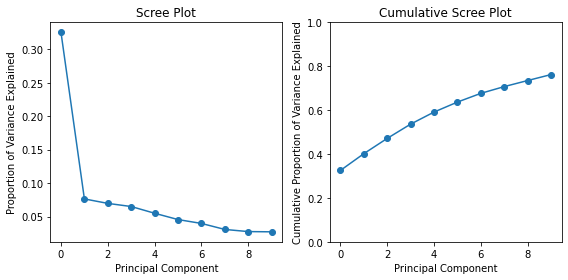

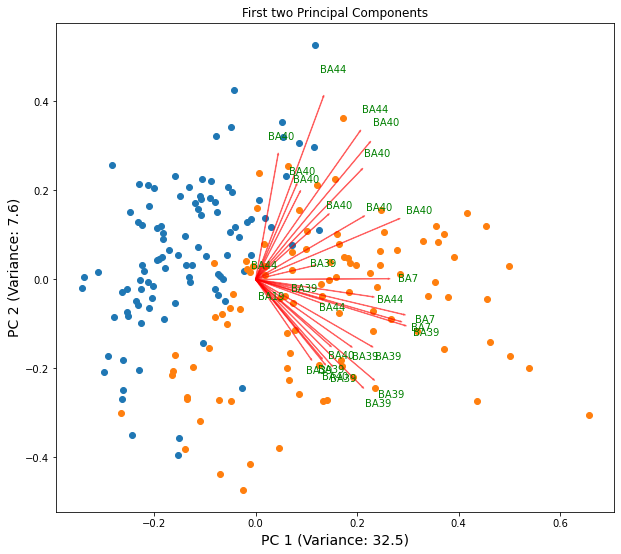

Subject: 2, doing 0-back
Subject: 2, doing 2-back
(200, 27) (200,)
0.7
[ 1.38250213 -0.53900504  0.07096516  0.26446366  1.043942    0.7830598
 -0.37130437  0.49809201 -0.01093928 -0.03505618  0.0658718  -0.12148868
 -0.7110862  -0.16407241 -0.19386232 -0.91731356 -0.34724507 -0.14710896
 -0.6820455   0.50760859 -0.39825437 -0.05912121  0.39042166 -0.29776121
  0.13418183  0.2775738  -0.08529365]


<Figure size 1296x1008 with 0 Axes>

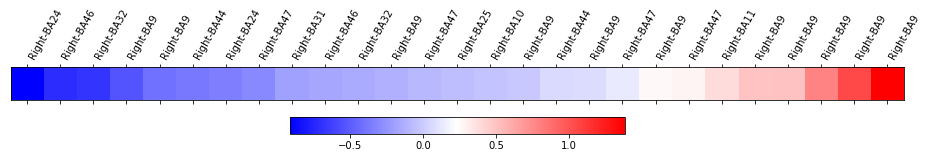

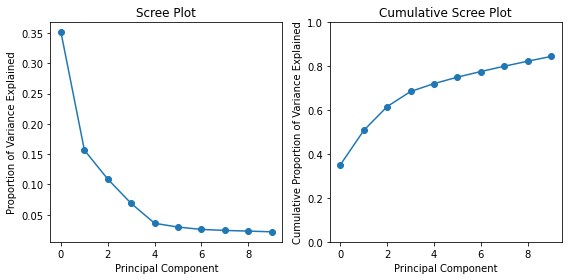

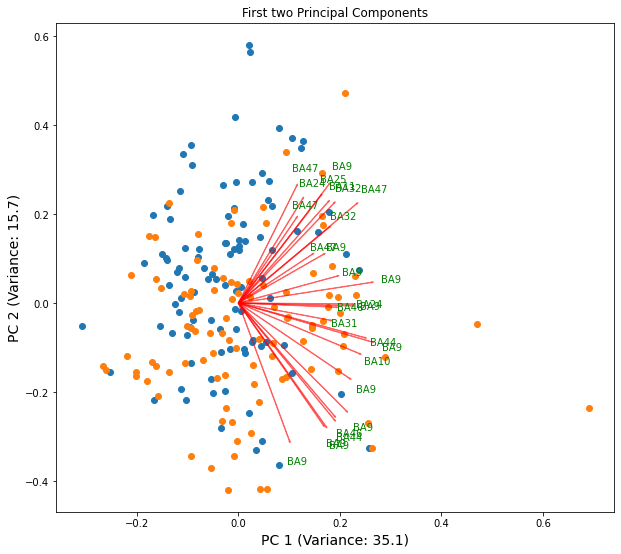

In [19]:
import sklearn
all_masks = []
def filter_motor_areas(names):
  MOTOR_AREAS = ['auditory', 'sensory', 'motor', 'ba22', 'ba4', 'ba6', 'ba8']

  mask = np.ones((len(names),), dtype=bool)  # include all by default
  for i, name in enumerate(names):
    nl = name.lower()
    if any(map(nl.endswith, MOTOR_AREAS[-3:])) or any(map(nl.__contains__, MOTOR_AREAS[:-3])):
      mask[i] = False
  return mask

def bandpower(data, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    band = np.asarray(band)
    low, high = band
    sf = SAMP_RATE

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

for subject in range(3):
  tasks_fft = []
  plt.figure(figsize=(18, 14))
  itr = 1
  X = []; y = []
  for task in TASKS:
    if task == '1-back': continue
    V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, subject, task)
    ba_names = []
    for loc in locs:
      x, yy, z = map(int, loc)
      nm = l4m.mni_to_region_name(x=x, y=yy, z=z)
      ba_names.append(list(nm)[3].__str__().split('"')[1])
    MN, MX = 50, 125
    names = [f'{ba_names[elec]}' for elec in range(len(locs))]
    mask_nonmotor = filter_motor_areas(names)
    V = V[:, mask_nonmotor]
    epochs = get_epochs(V, t_on - 400, t_on + 1600)
    all_fft, mean_band_amp = get_mean_band_amp(epochs, MN, MX)
    tasks_fft.append(all_fft.mean(0))
    all_masks.append(mask_nonmotor)
    names = [name for name, mask in zip(names, mask_nonmotor) if mask]
    #print(1 - (target == response).sum() / len(target))

    for trial in range(epochs.shape[0]):
      x = []
      for elec in range(epochs.shape[1]):
        x.append(bandpower(epochs[trial, elec], [MN, MX]))
      X.append(x); y.append(0 if task == '0-back' else 1)


    # response_epochs = epochs[response==1]
    # rs = []
    # for e in range(response_epochs.shape[1]):  # nelectrode
    #   if subject == 2: continue
    #   response_times = [(rt[response==1][r]-400) for r in range(len(rt[response==1]))]
    #   peak_times = [trial.argmax() for trial in response_epochs[:, e]]
    #   slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(peak_times, response_times)
    #   if (np.abs(r_value)>.8): print(e)
    #   rs.append(r_value)
    # ax = plt.subplot(2, 3, itr)
    # plt.hist(rs)
    # plt.title(f'{subject}, {task}')
    # itr += 1

  glm = sklearn.linear_model.LogisticRegression(random_state=8)
  X, y = np.array(X), np.array(y)
  scaler = sklearn.preprocessing.StandardScaler()
  X = scaler.fit_transform(X)
  print(X.shape, y.shape)
  pca = sklearn.decomposition.PCA(10)
  pca.fit(X)
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.3)
  glm.fit(X_train, y_train)
  yhat = glm.predict(X_test)
  print((y_test == yhat).sum()/len(y_test))

  ord = np.argsort(glm.coef_[0])
  sig = glm.coef_[0][ord]
  snames = np.array(names)[ord].tolist()
  print(glm.coef_[0])
  plt.matshow(sig.reshape((1, len(names))), cmap='bwr')
  plt.xticks(range(len(names)),
             snames, rotation=60, ha='left')
  plt.colorbar(orientation='horizontal')
  plt.yticks(())
  #plt.title(f'Coeffs of Sub-{subject}: High-gamma decoder')

  # variance captured by principal components
  var_PCs = pca.explained_variance_ratio_

  # transform data
  projected = pca.transform(X)

  PC_1 = projected[:, 0]
  PC_2 = projected[:, 1]

  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

  axes[0].plot(pca.explained_variance_ratio_, '-o')
  axes[0].set_xlabel('Principal Component')
  axes[0].set_ylabel('Proportion of Variance Explained')
  axes[0].title.set_text('Scree Plot')
  axes[1].plot(pca.explained_variance_ratio_.cumsum(), '-o')
  axes[1].set_xlabel('Principal Component')
  axes[1].set_ylabel('Cumulative Proportion of Variance Explained')
  axes[1].title.set_text('Cumulative Scree Plot')
  plt.ylim(0, 1)
  fig.tight_layout()
  plt.show()

  n_std = 3  # no. of standard deviations to show
  fig, ax = plt.subplots(figsize=(10, 9))

  xs = PC_1
  ys = PC_2
  scale_x = 1.0 / (xs.max() - xs.min())
  scale_y = 1.0 / (ys.max() - ys.min())

  for l in np.unique(y):
    ix = np.where(y == l)
    mean_PC_1 = np.mean(PC_1[ix])
    mean_PC_2 = np.mean(PC_2[ix])
    cov = np.cov(PC_1, PC_2)
    ax.scatter(xs[ix] * scale_x, PC_2[ix]*scale_y)
  plt.title('First two Principal Components')
  plt.xlabel(f'PC 1 (Variance: {var_PCs[0]*100:.1f})', fontsize=14)
  plt.ylabel(f'PC 2 (Variance: {var_PCs[1]*100:.1f})', fontsize=14)

  coeff = np.transpose(pca.components_)
  labels = names

  for i in range(len(names)):
    ax.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
    ax.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15,
            f'Var{i+1}' if labels is None else labels[i].split('-')[-1],
            color='g', ha='center', va='center')
  plt.show()
  
  # plt.figure(figsize=(18,18))
  # val = 0
  # for j in range(0, min(60, tasks_fft[0].shape[0])):
  #   ax = plt.subplot(6,10,j+1)
  #   plt.plot(tasks_fft[0][j], label='0-back')
  #   plt.plot(tasks_fft[1][j], label='1-back')
  #   plt.plot(tasks_fft[2][j], label='2-back')
  #   plt.title(f'{names[j]} {scipy.stats.ttest_ind(tasks_fft[0][j], tasks_fft[1][j])[1]:.2f}')
  #   #plt.title(f'{j} {scipy.stats.ttest_ind(tasks_fft[0][j], tasks_fft[1][j])[1]:.2f}')
  #   if scipy.stats.ttest_ind(tasks_fft[0][j], tasks_fft[1][j])[1] <= .05:
  #     val += 1
  #   plt.xticks([])
  # plt.tight_layout()
  # plt.legend()
  # plt.show()

In [21]:
pd.DataFrame({'Band': ['Alpha', 'Gamma', 'Hi-gamma', 'Ripple'], 'Acc: Sub-0': [0.57, .55, .75, .73], 'Acc: Sub-1': [0.7, .75, .97, 1.], 'Acc: Sub-2': [0.53, .43, .62, .48]})

Band  Acc: Sub-0  Acc: Sub-1  Acc: Sub-2
0     Alpha        0.57        0.70        0.53
1     Gamma        0.55        0.75        0.43
2  Hi-gamma        0.75        0.97        0.62
3    Ripple        0.73        1.00        0.48

# Analysis 4: Subsequent target retrievals in 0-back

## Peak Amplitude distribution: target vs distractor (0-back)

Subject: 0, doing 0-back


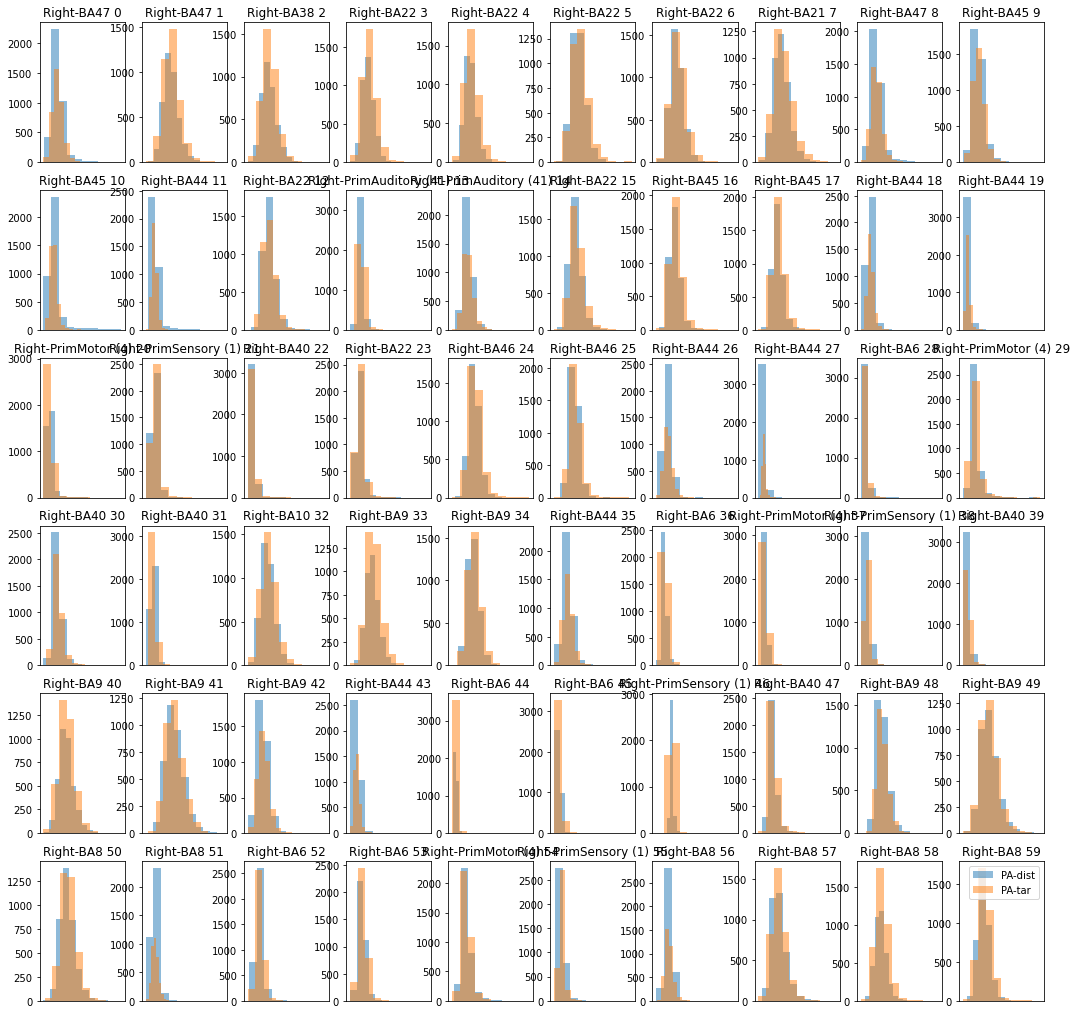

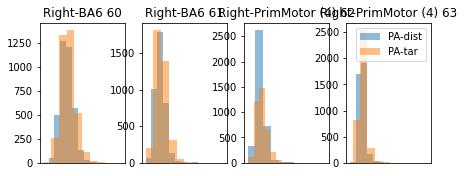

Subject: 1, doing 0-back


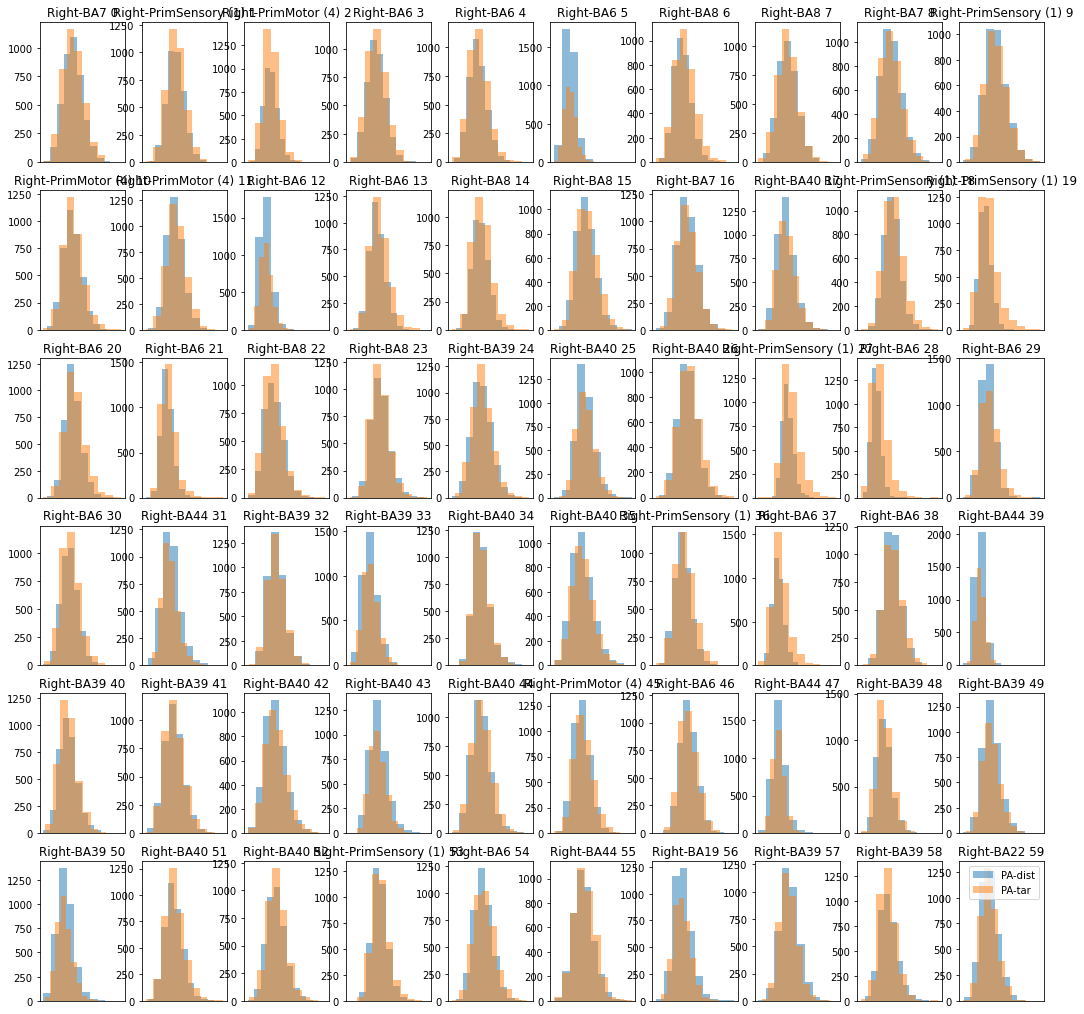

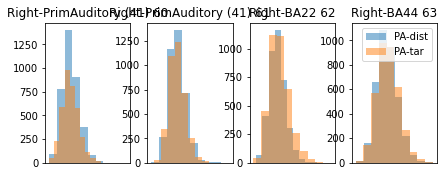

Subject: 2, doing 0-back


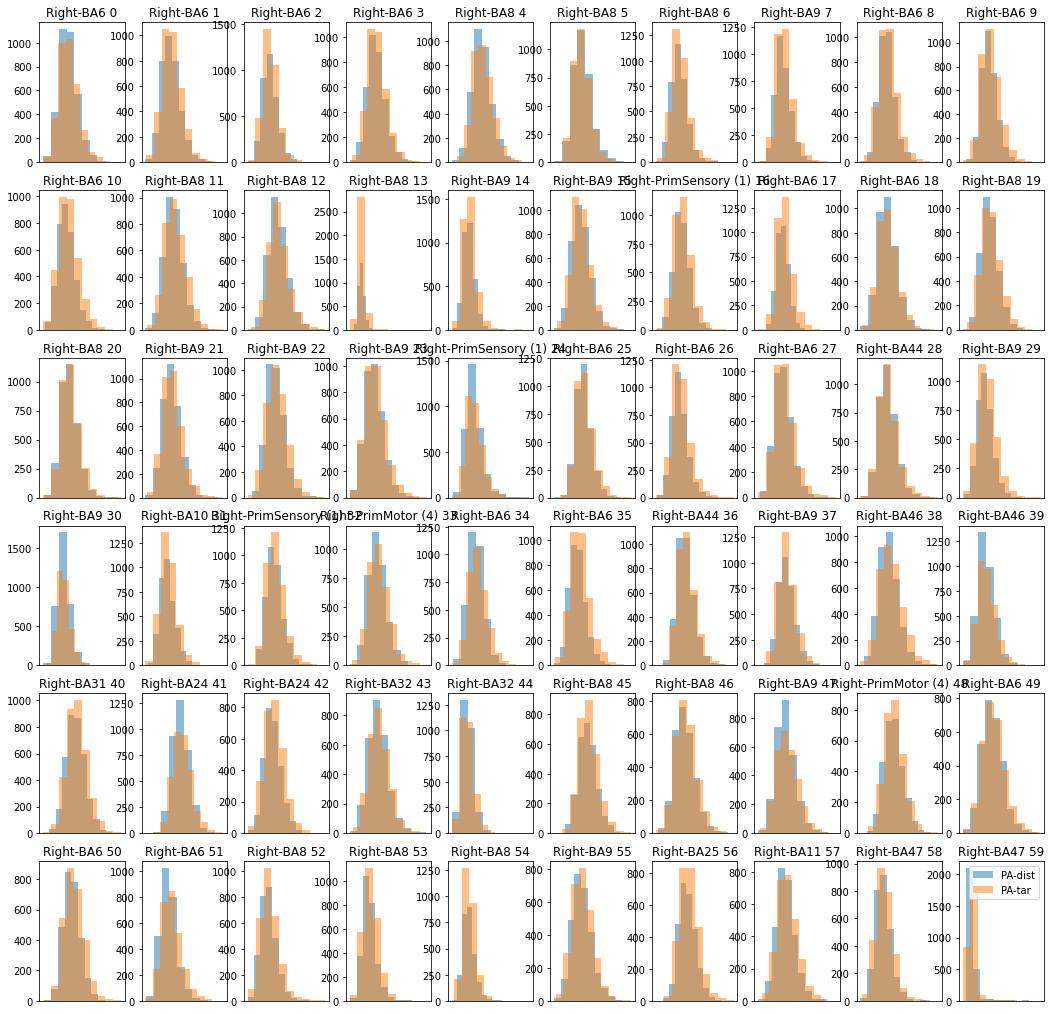

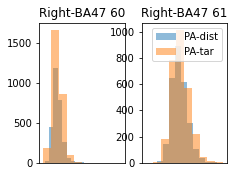

In [22]:
for subject in range(3):
  tasks_fft = []
  for task in ['0-back']:
    V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, subject, task)
    ba_names = []
    for loc in locs:
      x, y, z = map(int, loc)
      nm = l4m.mni_to_region_name(x=x, y=y, z=z)
      ba_names.append(list(nm)[3].__str__().split('"')[1])
    # high-pass filter above 50 Hz
    b, a = scipy.signal.butter(5, [50], btype = 'high', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    b, a = scipy.signal.butter(5, [125], btype = 'low', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    names = [f'{ba_names[elec]} {elec}' for elec in range(len(locs))]
    epochs = get_epochs(V, t_on - 400, t_on + 1600)
    distractor_ecog, target_ecog = split_labeled_groups(epochs, target)

    plt.figure(figsize=(18,18))
    for j in range(60):
      ax = plt.subplot(6,10,j+1)
      signal = distractor_ecog[-22:, j]
      peaksamp = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        peaksamp.extend([signal[trial][peak] for peak in peaks])
      plt.hist(peaksamp, alpha=.5, label='PA-dist')
      signal = target_ecog[:, j]
      peaksamp = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        peaksamp.extend([signal[trial][peak] for peak in peaks])
      plt.hist(peaksamp, alpha=.5, label='PA-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.legend()
    plt.show()
    plt.figure(figsize=(18,18))
    for j in range(60, epochs.shape[1]):
      ax = plt.subplot(6,10,j-59)
      signal = distractor_ecog[:22, j]
      peaksamp = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        peaksamp.extend([signal[trial][peak] for peak in peaks])
      plt.hist(peaksamp, alpha=.5, label='PA-dist')
      signal = target_ecog[:, j]
      peaksamp = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        peaksamp.extend([signal[trial][peak] for peak in peaks])
      plt.hist(peaksamp, alpha=.5, label='PA-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.legend()
    plt.show()

## Peak amplitude distribution: subsequent trials with targets (0-back)

Subject: 0, doing 0-back


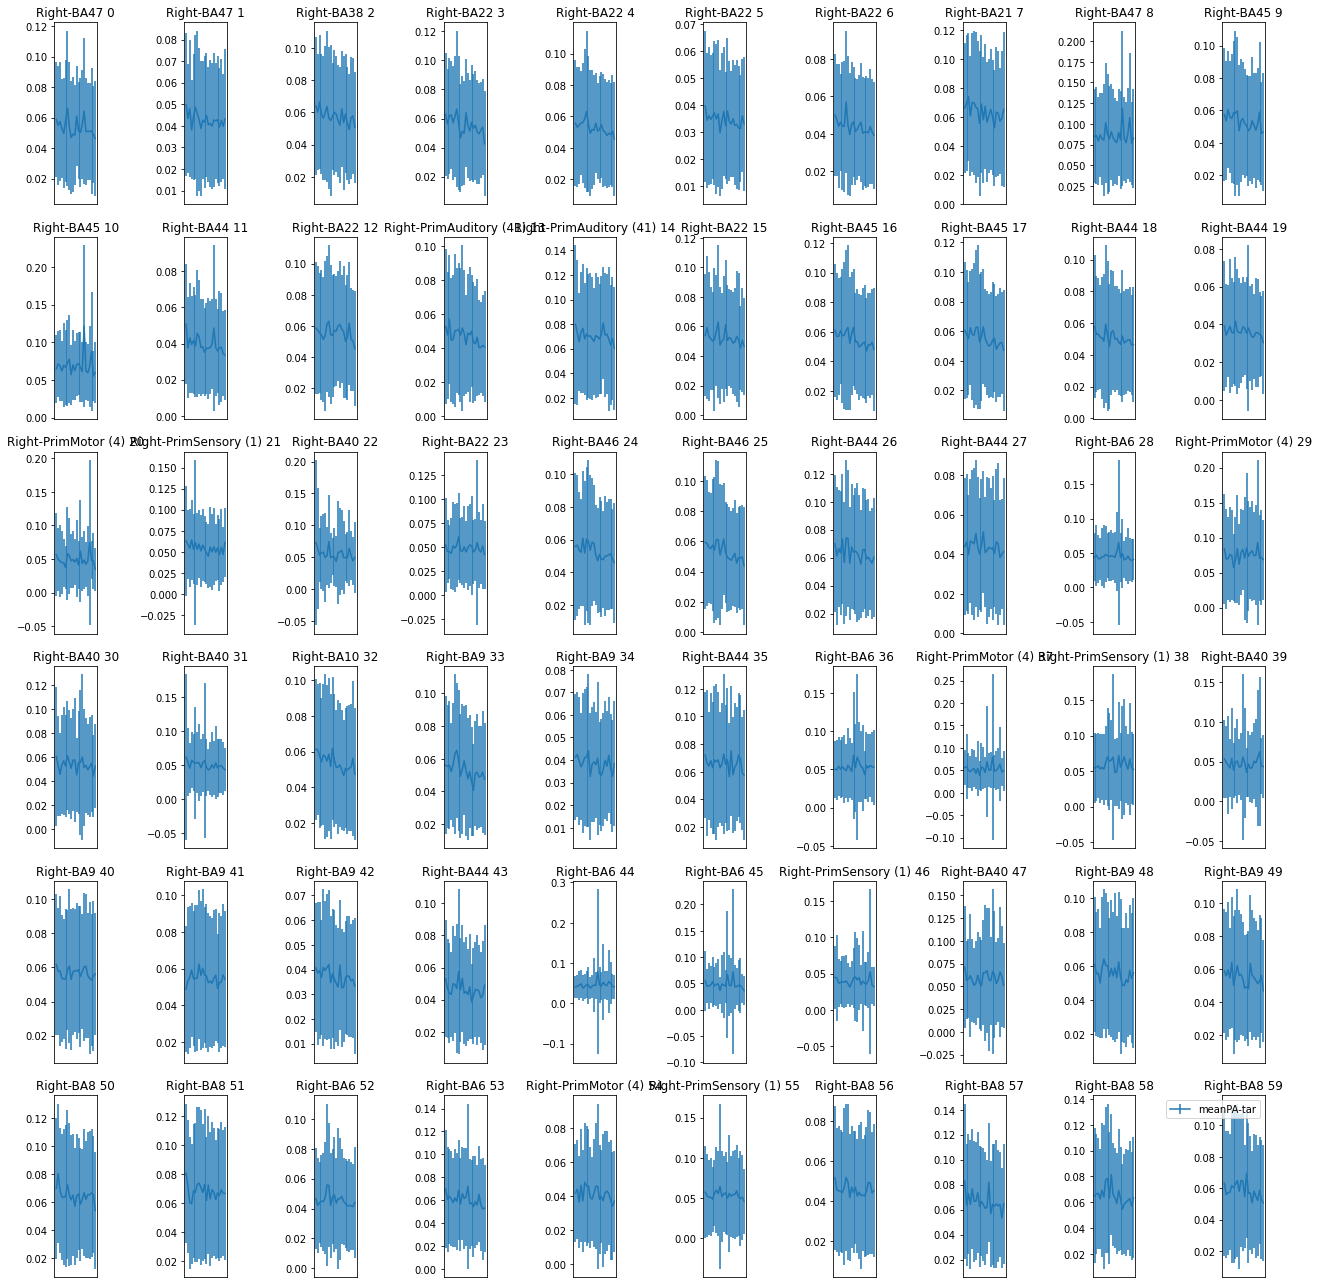

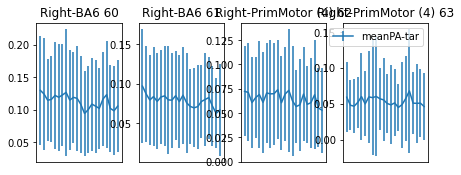

Subject: 1, doing 0-back


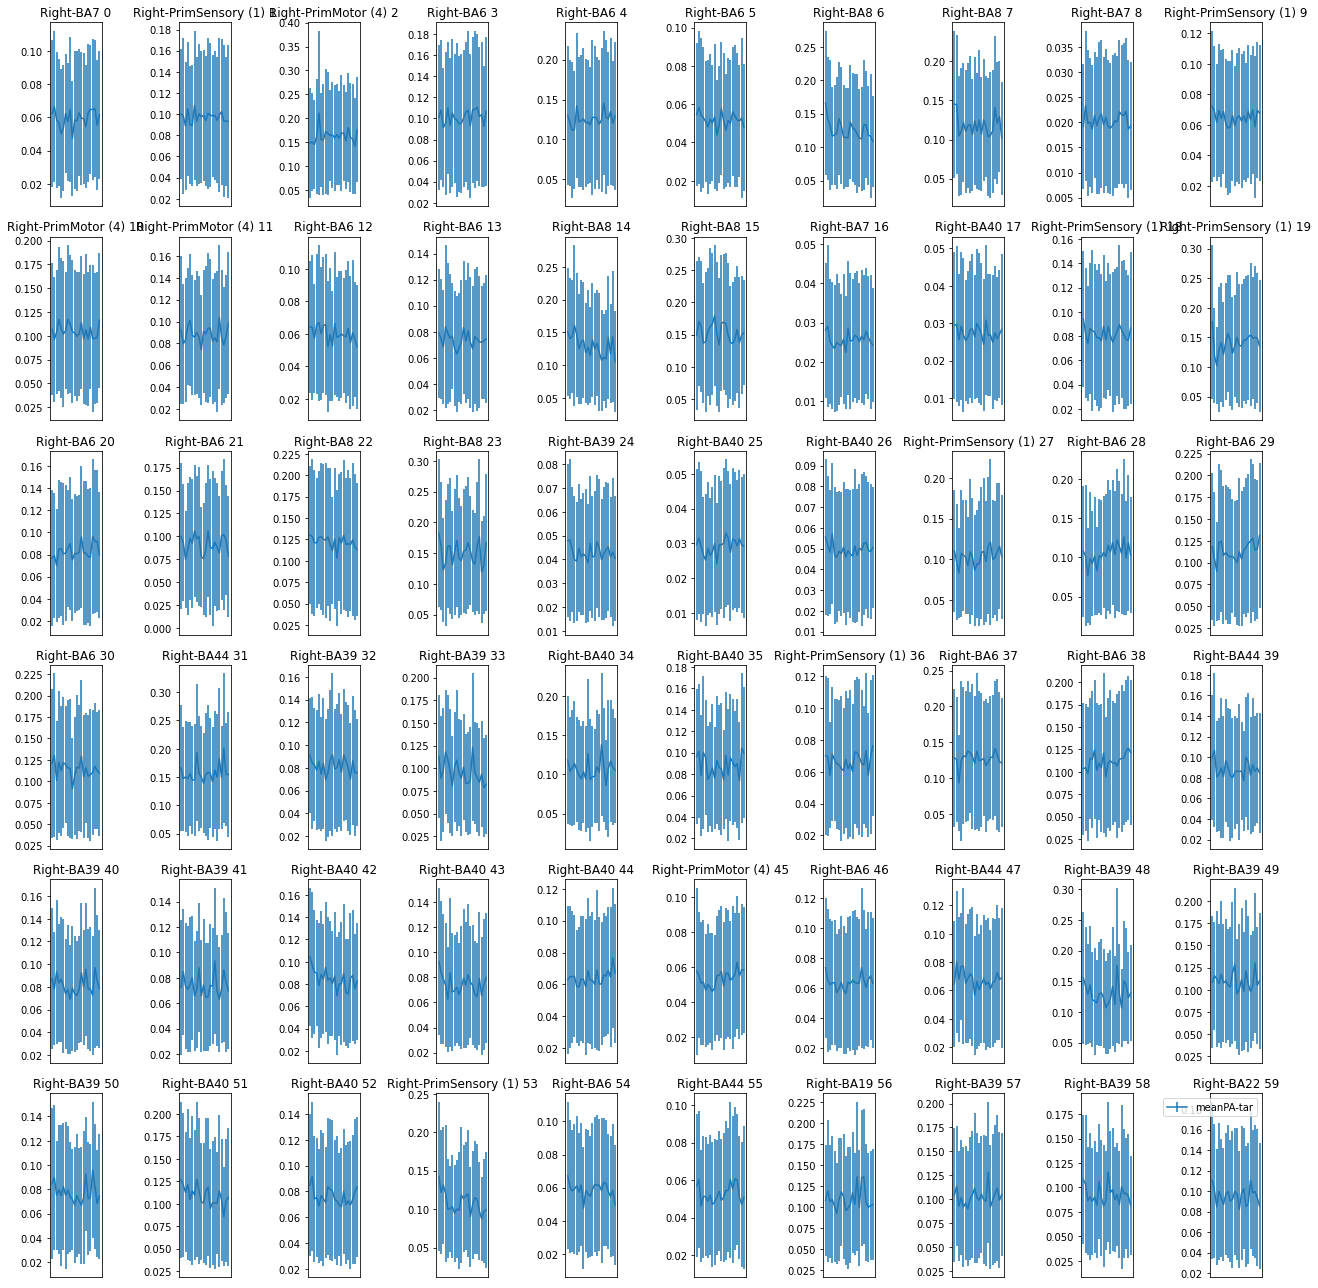

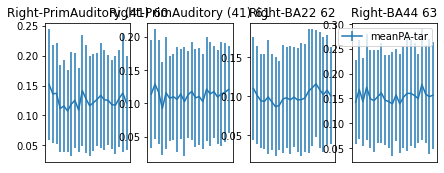

Subject: 2, doing 0-back


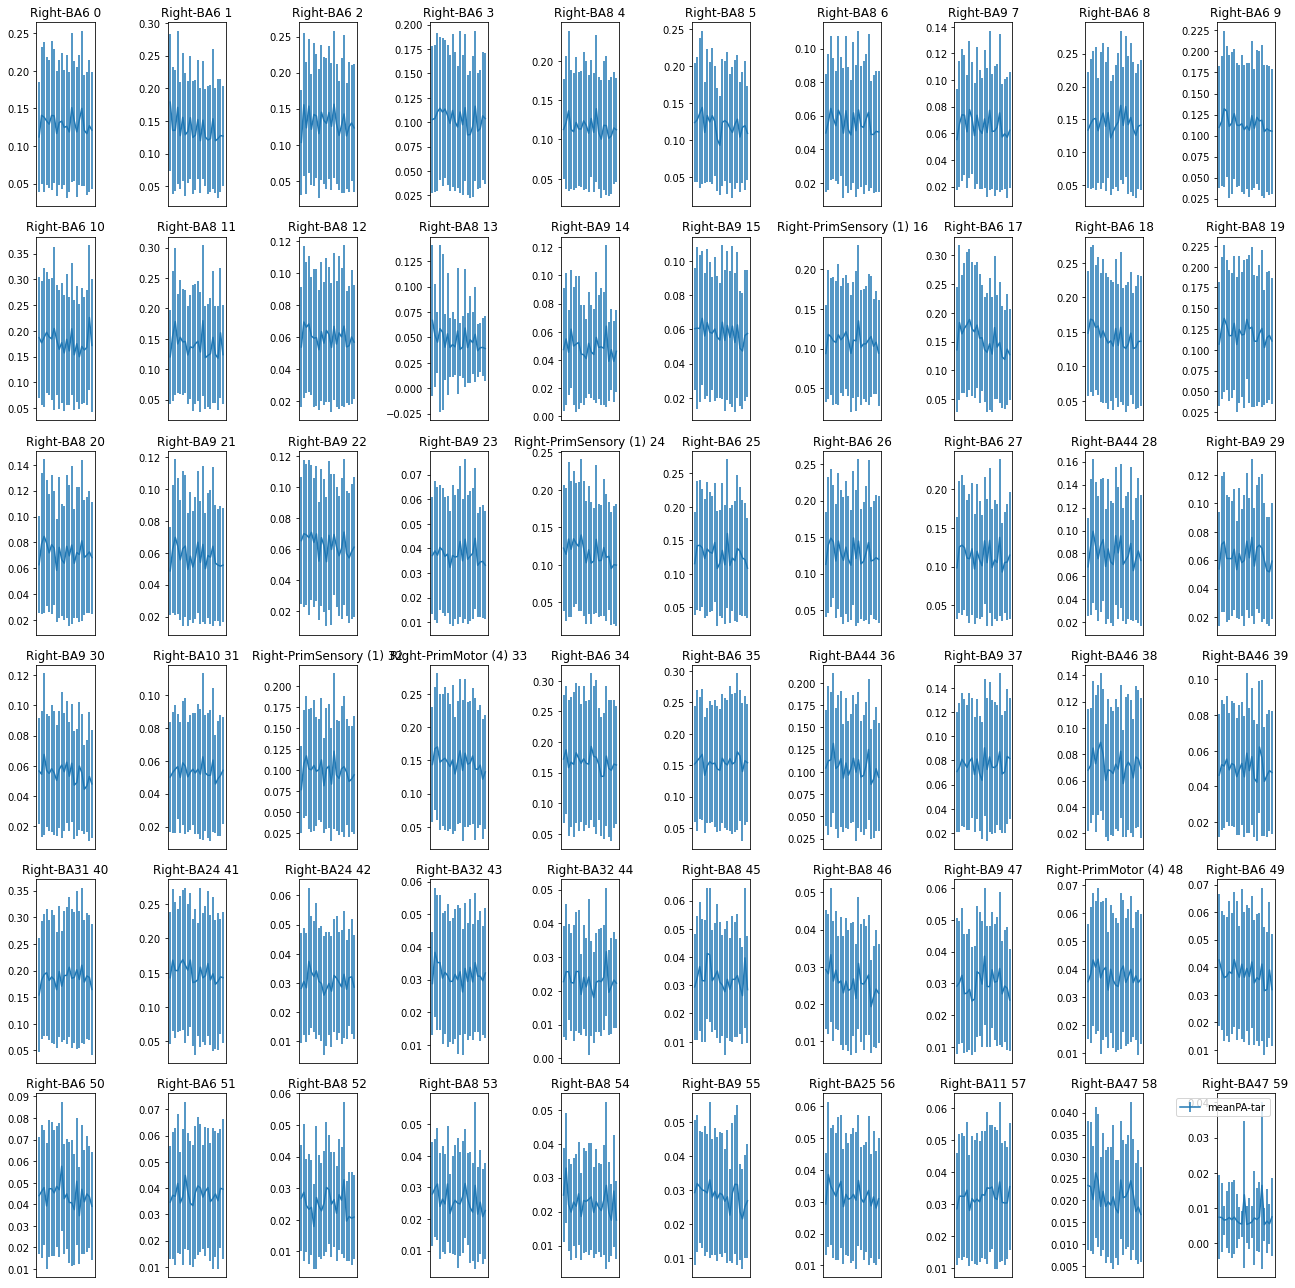

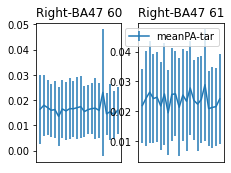

In [23]:
for subject in range(3):
  tasks_fft = []
  for task in ['0-back']:
    V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, subject, task)
    ba_names = []
    for loc in locs:
      x, y, z = map(int, loc)
      nm = l4m.mni_to_region_name(x=x, y=y, z=z)
      ba_names.append(list(nm)[3].__str__().split('"')[1])
    # high-pass filter above 50 Hz
    b, a = scipy.signal.butter(5, [50], btype = 'high', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    b, a = scipy.signal.butter(5, [125], btype = 'low', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    names = [f'{ba_names[elec]} {elec}' for elec in range(len(locs))]
    epochs = get_epochs(V, t_on, t_on + 1500)
    distractor_ecog, target_ecog = split_labeled_groups(epochs, target)

    plt.figure(figsize=(18,18))
    for j in range(60):
      ax = plt.subplot(6,10,j+1)
      signal = target_ecog[:, j]

      pa_mean = []
      err = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        peaksamp = np.array([signal[trial][peak] for peak in peaks])
        pa_mean.append(peaksamp.mean())
        err.append(peaksamp.std())

      plt.errorbar(range(len(pa_mean)), pa_mean, yerr=err, label=f'meanPA-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.tight_layout()
    plt.legend()
    plt.show()
    plt.figure(figsize=(18,18))
    for j in range(60, epochs.shape[1]):
      ax = plt.subplot(6,10,j-59)
      signal = target_ecog[:, j]
      pa_mean = []
      err = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        peaksamp = np.array([signal[trial][peak] for peak in peaks])
        pa_mean.append(peaksamp.mean())
        err.append(peaksamp.std())
      plt.errorbar(range(len(pa_mean)), pa_mean, yerr=err, label=f'meanPA-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.legend()
    plt.show()

## Inter-peak interval distribution: target vs distractor (0-back)

Subject: 0, doing 0-back


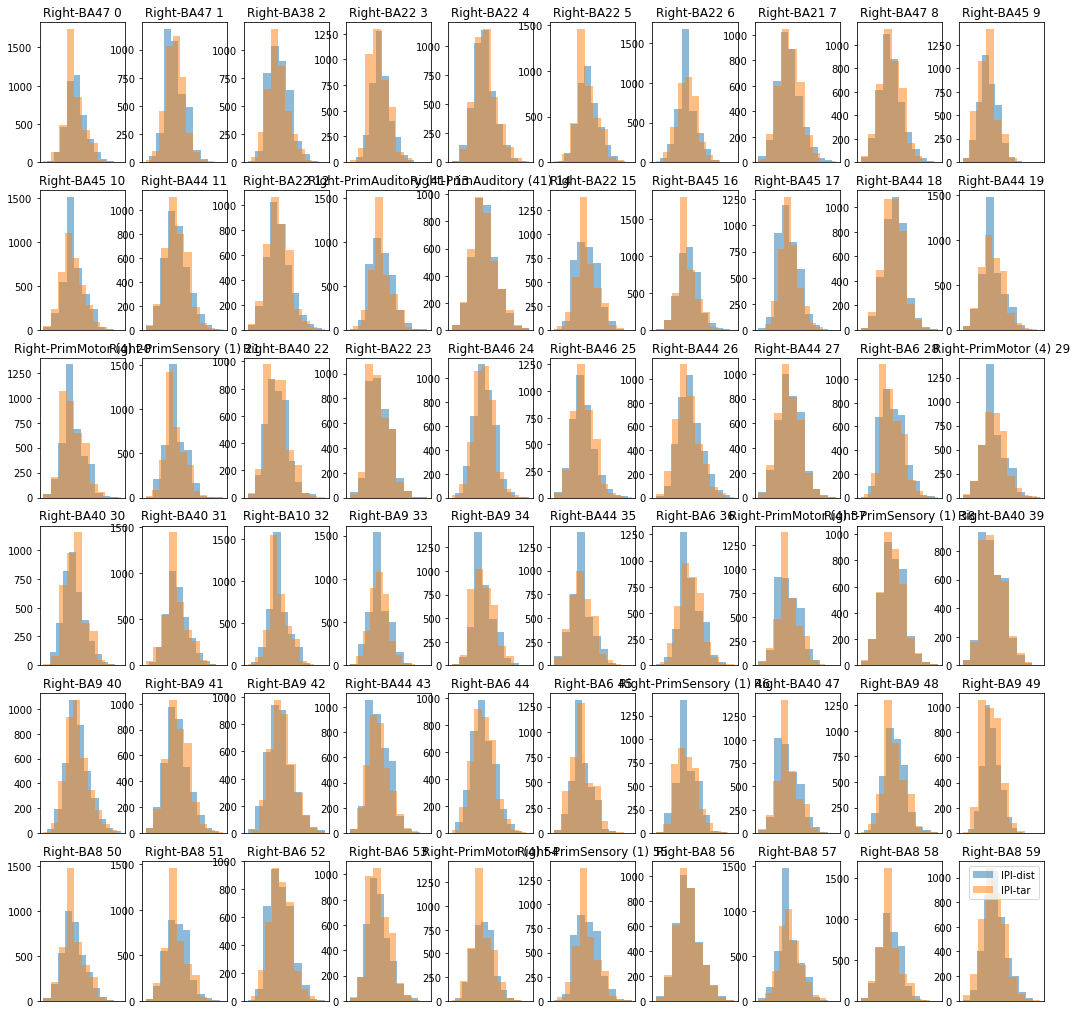

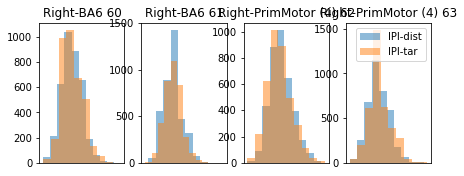

Subject: 1, doing 0-back


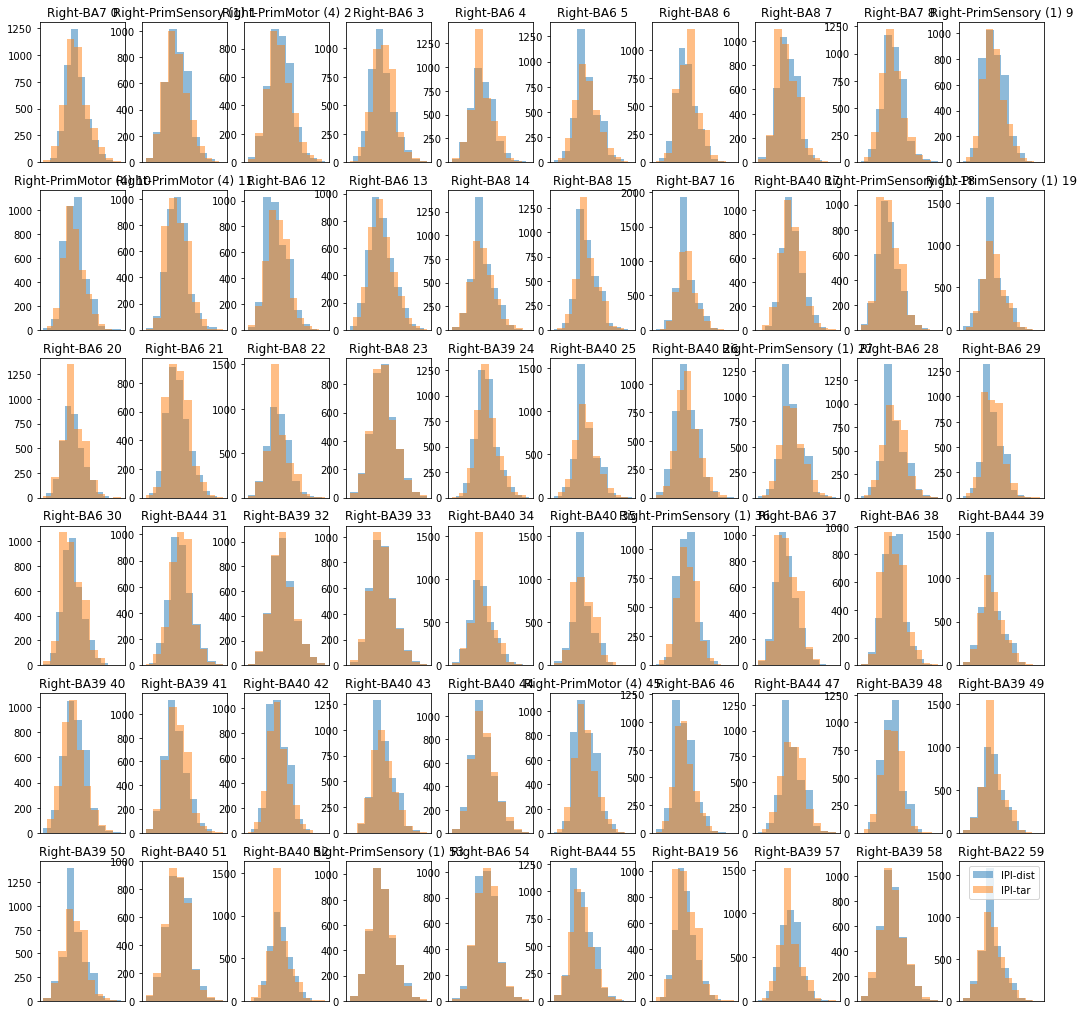

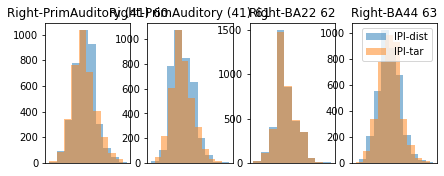

Subject: 2, doing 0-back


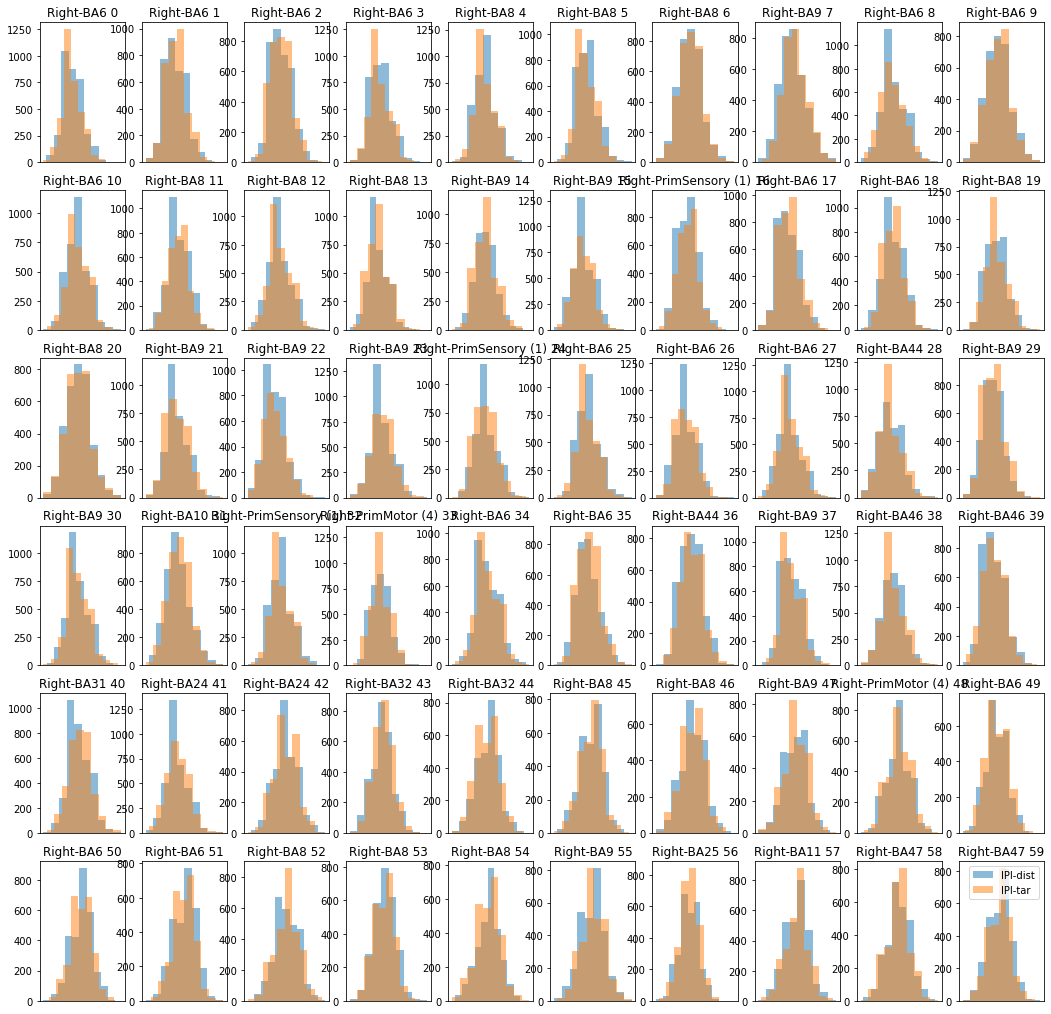

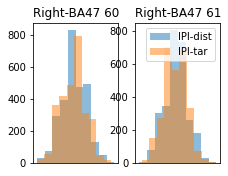

In [24]:
for subject in range(3):
  tasks_fft = []
  for task in ['0-back']:
    V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, subject, task)
    ba_names = []
    for loc in locs:
      x, y, z = map(int, loc)
      nm = l4m.mni_to_region_name(x=x, y=y, z=z)
      ba_names.append(list(nm)[3].__str__().split('"')[1])
    # high-pass filter above 50 Hz
    b, a = scipy.signal.butter(5, [50], btype = 'high', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    b, a = scipy.signal.butter(5, [125], btype = 'low', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    names = [f'{ba_names[elec]} {elec}' for elec in range(len(locs))]
    epochs = get_epochs(V, t_on - 500, t_on + 1500)
    distractor_ecog, target_ecog = split_labeled_groups(epochs, target)

    plt.figure(figsize=(18,18))
    for j in range(60):
      ax = plt.subplot(6,10,j+1)
      signal = distractor_ecog[-22:, j]
      ipi = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        ipi.extend(list(np.diff(peaks)))
      plt.hist(ipi, alpha=.5, label='IPI-dist')
      signal = target_ecog[:, j]
      ipi = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        ipi.extend(list(np.diff(peaks)))
      plt.hist(ipi, alpha=.5, label='IPI-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.legend()
    plt.show()
    plt.figure(figsize=(18,18))
    for j in range(60, epochs.shape[1]):
      ax = plt.subplot(6,10,j-59)
      signal = distractor_ecog[:22, j]
      ipi = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        ipi.extend(list(np.diff(peaks)))
      plt.hist(ipi, alpha=.5, label='IPI-dist')
      signal = target_ecog[:, j]
      ipi = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        ipi.extend(list(np.diff(peaks)))
      plt.hist(ipi, alpha=.5, label='IPI-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.legend()
    plt.show()

## Inter-peak interval trend: subsequent trials with target (0-back)

Subject: 0, doing 0-back


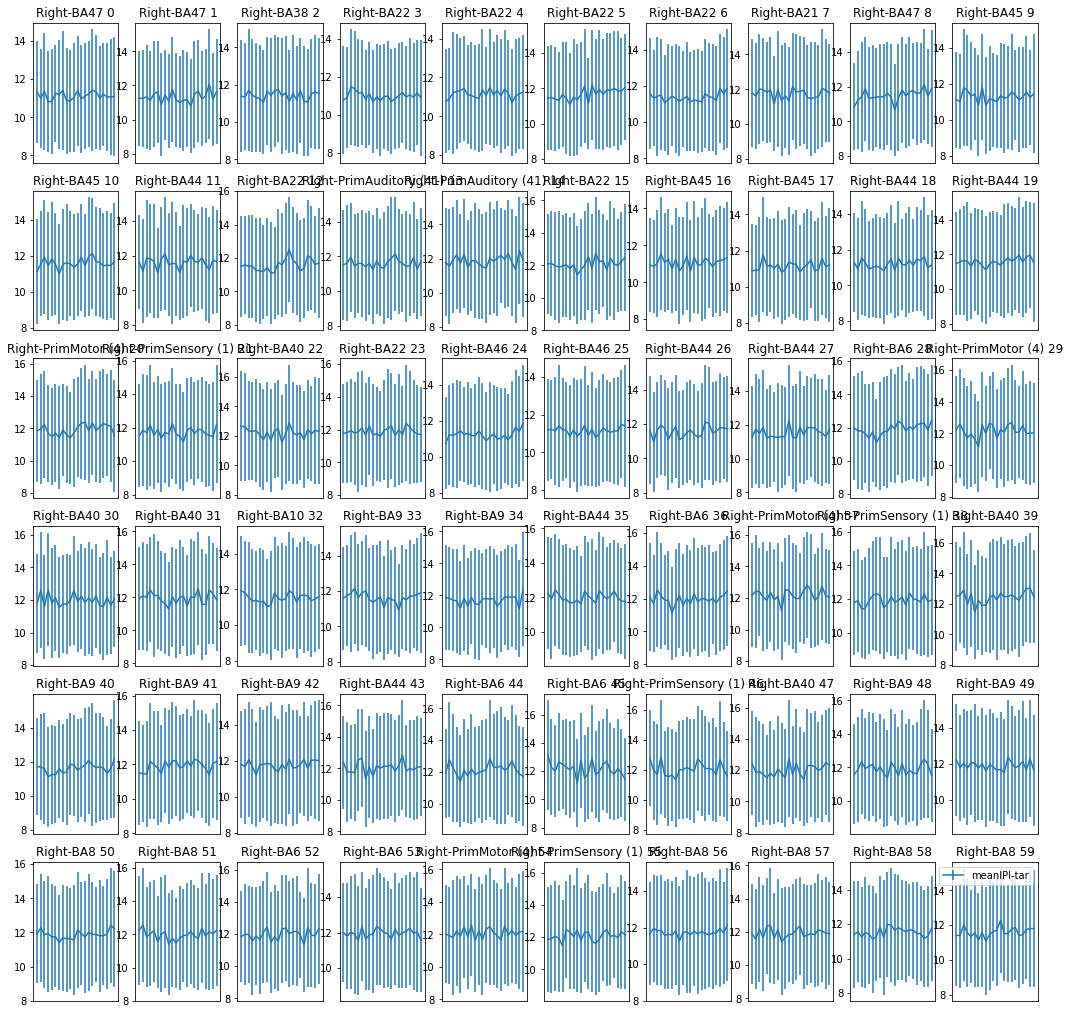

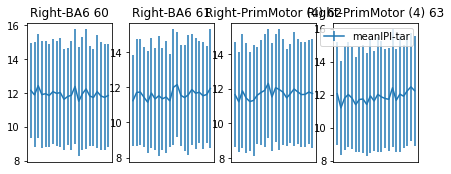

Subject: 1, doing 0-back


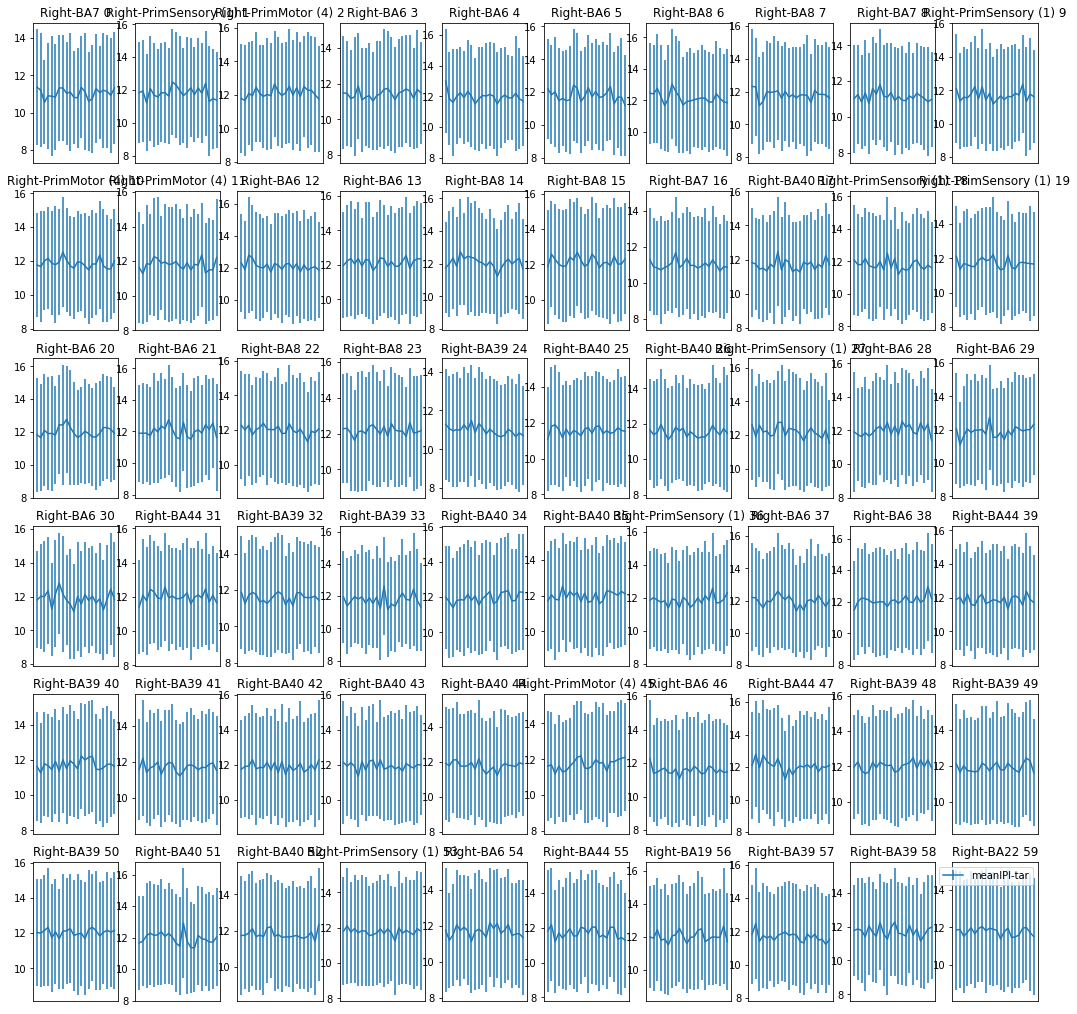

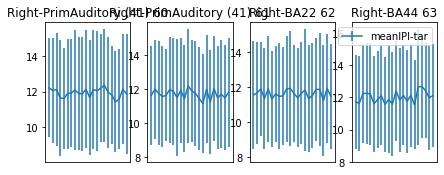

Subject: 2, doing 0-back


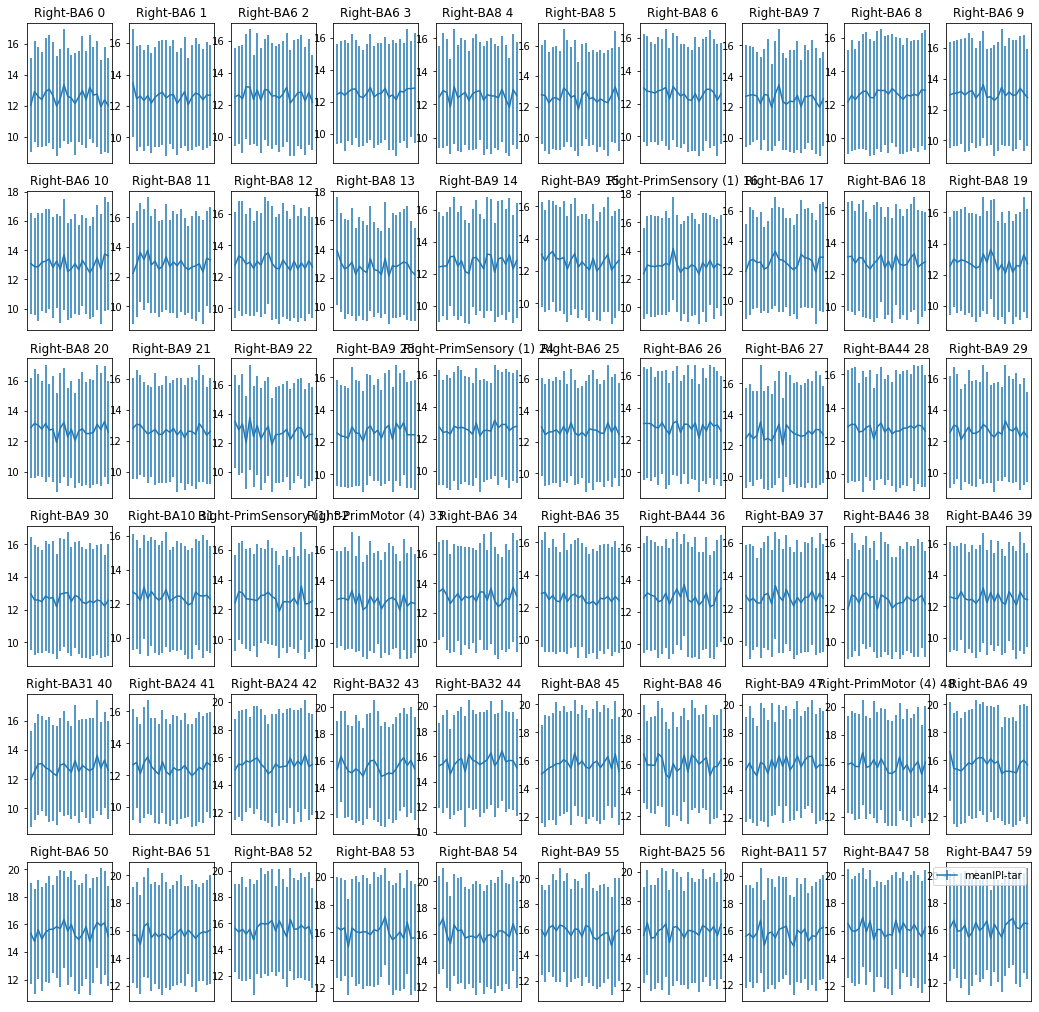

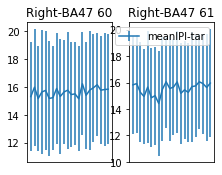

In [25]:
for subject in range(3):
  tasks_fft = []
  for task in ['0-back']:
    V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, subject, task)
    ba_names = []
    for loc in locs:
      x, y, z = map(int, loc)
      nm = l4m.mni_to_region_name(x=x, y=y, z=z)
      ba_names.append(list(nm)[3].__str__().split('"')[1])
    # high-pass filter above 50 Hz
    b, a = scipy.signal.butter(5, [50], btype = 'high', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    b, a = scipy.signal.butter(5, [125], btype = 'low', fs=SAMP_RATE)
    V = scipy.signal.filtfilt(b,a,V,0)

    names = [f'{ba_names[elec]} {elec}' for elec in range(len(locs))]
    epochs = get_epochs(V, t_on - 500, t_on + 1500)
    distractor_ecog, target_ecog = split_labeled_groups(epochs, target)

    plt.figure(figsize=(18,18))
    for j in range(60):
      ax = plt.subplot(6,10,j+1)
      signal = target_ecog[:, j]

      ipi_mean = []; err = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        ipi = np.diff(peaks)
        ipi_mean.append(ipi.mean())
        err.append(ipi.std())
      plt.errorbar(range(len(ipi_mean)), ipi_mean, yerr=err, label=f'meanIPI-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.legend()
    plt.show()
    plt.figure(figsize=(18,18))
    for j in range(60, epochs.shape[1]):
      ax = plt.subplot(6,10,j-59)
      signal = target_ecog[:, j]
      ipi_mean = []; err = []
      for trial in range(signal.shape[0]):
        peaks = scipy.signal.find_peaks(signal[trial])[0]
        ipi = np.diff(peaks)
        ipi_mean.append(ipi.mean())
        err.append(ipi.std())
      plt.errorbar(range(len(ipi_mean)), ipi_mean, yerr=err, label=f'meanIPI-tar')
      plt.title(names[j])
      plt.xticks([])
    plt.legend()
    plt.show()

# Analysis 5: Remove motor electrodes and recompare workload differences

In [26]:
for subject in range(3):
  tasks_fft = []
  for task in TASKS:
    V, stim_id, t_on, t_off, target, response, rt, locs = load_data(FILE, subject, task)
    ba_names = []
    for loc in locs:
      x, y, z = map(int, loc)
      nm = l4m.mni_to_region_name(x=x, y=y, z=z)
      ba_names.append(list(nm)[3].__str__().split('"')[1])

    names = [f'{ba_names[elec]} {elec}' for elec in range(len(locs))]
    filtered_names = []
    for name in names:
      if (('motor' not in name.lower()) and ('ba6' not in name.lower()) and ('ba8' not in name.lower()) and ('ba4' not in name.lower())):
        filtered_names.append(name)
    print(len(filtered_names))

Subject: 0, doing 0-back
23
Subject: 0, doing 1-back
23
Subject: 0, doing 2-back
23
Subject: 1, doing 0-back
25
Subject: 1, doing 1-back
25
Subject: 1, doing 2-back
25
Subject: 2, doing 0-back
22
Subject: 2, doing 1-back
22
Subject: 2, doing 2-back
22
